# Analysis of simulations


In [1]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna 
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
import scipy
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')
import os
import operator
import logomaker
import matplotlib
import statsmodels
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle

import matplotlib.patches as mpatches
from localcider.sequenceParameters import SequenceParameters
import localcider
from statsmodels.formula.api import ols
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import unicodedata
# custom functions
# import StableAnalaysisFunctions as saf


In [2]:
Folder = '20211004/'

if (os.path.isdir('Figures/')):
    print 'Figures folder exists'
else:
    os.mkdir('Figures')
if (os.path.isdir('Figures/'+Folder)):
    print 'Today I will save files in Figures/%s' %Folder
else:
    os.mkdir('Figures/'+Folder)
    os.mkdir('Figures/'+Folder+'/Logos')
    os.mkdir('Figures/'+Folder+'/SequenceLists')
    os.mkdir('Figures/'+Folder+'/BarGraphs')
    os.mkdir('Figures/'+Folder+'/LineGraphs')
if (os.path.isdir('SimulationSequenceLists/')):
    print 'folder exists'
else:    
    os.mkdir('SimulationSequenceLists')

    
    
## load data frames
SimDF = pd.read_csv('Figures/SupplementalDataset9_simulationData.csv')

Figures folder exists
Today I will save files in Figures/20211004/
folder exists


In [3]:

## variables

summaryCols = [ 'MutName','HandDesigned', u'WT','CITED2_N', 'stat3', 'Hif1-AD2_46',
       'p65_L2Y', 'p65', 'vp16N_C', u'ADseq','Activity_Mean_MSS18']

TitleDict ={'CITED2_N':'CITED2', 'Hif1-AD2_46':'Hif1'+unicodedata.lookup('greek small letter alpha'), 'vp16N_C':'VP16 H1', 'stat3':'Stat3', 'p65':'p65'}


currentItem ='Activity_Mean_MSS18'
currentSTD  ='Activity_std_MSS18'
# Useful plotting variables


## support variables
ADlist = [ 'CITED2_N','Hif1-AD2_46','vp16N_C','stat3','p65']
cited, hif1a,vp16,stat3,p65 = ADlist
ExtendedADlist = [ 'CITED2_N','Hif1-AD2_46','vp16N_C','stat3','p65','p65_L2Y']
ADCoordinates={ 'CITED2_N':[220,258],# isoform 1
               'Hif1-AD2_46':[781,896],# isoform 1
               'vp16N_C':[415,453], #from blast
               'stat3':[719,764],# isoform 1
               'p65':[521,551]}# isoform 1
## WT support dictionaries
WTname2seqDict,WTseq2nameDict,WTname2currentItemDict,WTname2currentSEMDict = pickle.load(open('../Analysis/pickleFiles/WTDictionaries','r'))
WTname2currentItemDict = WTname2currentItemDict[currentItem]
WTname2currentSEMDict = WTname2currentSEMDict[currentItem]

In [4]:
a = SimDF[SimDF[hif1a]]
print('There are %i Hif1a variants, including WT' %len(set(a.sim_id)))

There are 21 Hif1a variants, including WT


CITED2_N Charge n = 1060 
vp16N_C Charge n = 730 
CITED2_N Aromatics n = 1060 
vp16N_C Aromatics n = 730 


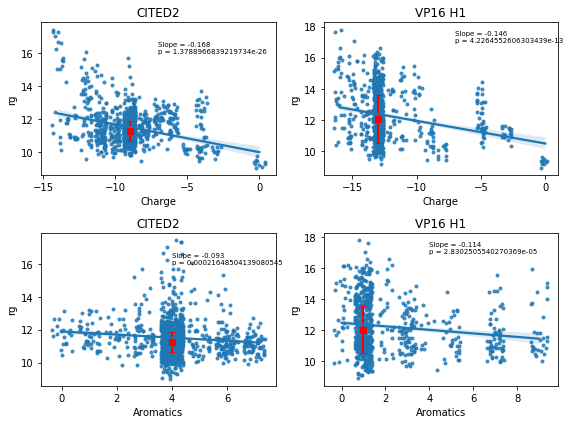

In [6]:
# featurepairs = [['Charge','rg'],['Aromatics','rg'],['Aromatics','WFYL_exp']]
featurepairs = [['Charge','rg'],['Aromatics','rg']]

labelDict = {'rg':'Radius of gyration (size)','Charge':'Charge','Aromatics':'Aromatics','WFY_exp_norm':'Normalized exposure of aromatics',
             'CountFYWL': 'W,F,Y,L Count', 'WFYL_exp_norm':'Normalized exposure of W,F,Y,L',
            'WFYL_exp':'Exposure of W,F,Y,L'}
yloc ={vp16:17,cited:16,hif1a:13}
xloc={'Charge':-7, 'Aromatics':4,'WFYL_exp':5,} 

# for yfeature in ['rg','WFYL_exp','WFY_exp','trp', 'phe','tyr', 'leu']:
fig = plt.figure(figsize=(8,6))
for j,featurepair in enumerate(featurepairs):
    xfeature,yfeature = featurepair    
    for k,ad in enumerate([cited,vp16]):
#             for j,simtype in enumerate(['coil_start','helical_start']):
        plt.subplot(2,2,1+j*2+k)
        indx = SimDF[ad]&(SimDF.sim_type=='coil_start')&(SimDF.Charge<1)&(SimDF.Aromatics<10)
        tempDF = SimDF[indx]
        print '%s %s n = %i ' %(ad,xfeature,sum(indx))

        wt = SimDF[ad] & SimDF.WT&(SimDF.sim_type=='coil_start')
        tempwt = SimDF[wt]
        wtmean= np.mean(tempwt[yfeature])
        wtstd = np.std(tempwt[yfeature])
        x = np.median(tempwt[xfeature])
#             plt.scatter(tempwt[xfeature]+1,tempwt[yfeature],c='r',s=1)

        plt.title(TitleDict[ad])
        plt.errorbar(x,wtmean,wtstd,fmt='s',capsize=3, elinewidth=2,c='r')

        sns.regplot(x=xfeature,y=yfeature,data=tempDF,x_jitter=.4,marker='.',order=1)
        
        #compute regression
        X = statsmodels.api.add_constant(tempDF[xfeature])
        mod = statsmodels.api.GLS(tempDF[yfeature],X)
        reg = mod.fit()
        params = reg.params
        pvalues =reg.pvalues
        plt.text(xloc[xfeature],yloc[ad],'Slope = %.3f \np = %r'%(params[1],pvalues[1]),fontsize=7)


        if xfeature=='Charge':
            plt.xticks([-15,-10,-5,0])
plt.tight_layout()

plt.savefig('Figures/'+Folder+'20211004_SimsSuppFigScatter.pdf')
plt.show()

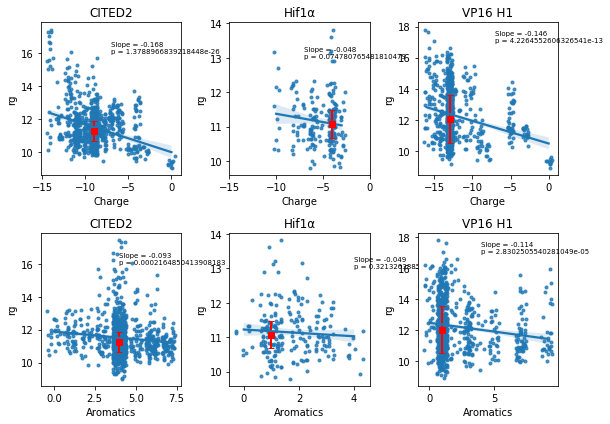

In [14]:
# featurepairs = [['Charge','rg'],['Aromatics','rg'],['Aromatics','WFYL_exp']]
featurepairs = [['Charge','rg'],['Aromatics','rg']]

labelDict = {'rg':'Radius of gyration (size)','Charge':'Charge','Aromatics':'Aromatics','WFY_exp_norm':'Normalized exposure of aromatics',
             'CountFYWL': 'W,F,Y,L Count', 'WFYL_exp_norm':'Normalized exposure of W,F,Y,L',
            'WFYL_exp':'Exposure of W,F,Y,L'}
yloc ={vp16:17,cited:16,hif1a:13}
xloc={'Charge':-7, 'Aromatics':4,'WFYL_exp':5,} 

# for yfeature in ['rg','WFYL_exp','WFY_exp','trp', 'phe','tyr', 'leu']:
fig = plt.figure(figsize=(8,6))
for j,featurepair in enumerate(featurepairs):
    xfeature,yfeature = featurepair    
    for k,ad in enumerate([cited,hif1a,vp16]):
#             for j,simtype in enumerate(['coil_start','helical_start']):
        plt.subplot(2,3,1+j*3+k)
        indx = SimDF[ad]&(SimDF.sim_type=='coil_start')&(SimDF.Charge<1)&(SimDF.Aromatics<10)
        tempDF = SimDF[indx]

        wt = SimDF[ad] & SimDF.WT&(SimDF.sim_type=='coil_start')
        tempwt = SimDF[wt]
        wtmean= np.mean(tempwt[yfeature])
        wtstd = np.std(tempwt[yfeature])
        x = np.median(tempwt[xfeature])
#             plt.scatter(tempwt[xfeature]+1,tempwt[yfeature],c='r',s=1)

        plt.title(TitleDict[ad])
        plt.errorbar(x,wtmean,wtstd,fmt='s',capsize=3, elinewidth=2,c='r')

        sns.regplot(x=xfeature,y=yfeature,data=tempDF,x_jitter=.4,marker='.',order=1)
        
        #compute regression
        X = statsmodels.api.add_constant(tempDF[xfeature])
        mod = statsmodels.api.GLS(tempDF[yfeature],X)
        reg = mod.fit()
#         print( 'parameters ',reg.params)
#         print( 'p values ',reg.pvalues)
        params = reg.params
        pvalues =reg.pvalues
        plt.text(xloc[xfeature],yloc[ad],'Slope = %.3f \np = %r'%(params[1],pvalues[1]),fontsize=7)


        if xfeature=='Charge':
            plt.xticks([-15,-10,-5,0])
plt.tight_layout()

plt.savefig('Figures/'+Folder+'20211004_SimsSuppFigScatter.pdf')
plt.show()

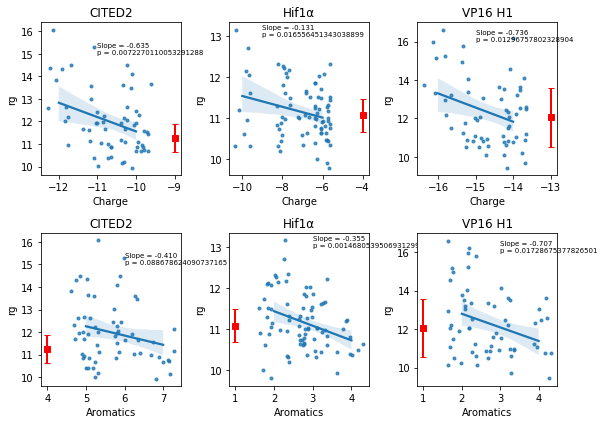

In [15]:
# featurepairs = [['Charge','rg'],['Aromatics','rg'],['Aromatics','WFYL_exp']]
featurepairs = [['Charge','rg'],['Aromatics','rg']]

labelDict = {'rg':'Radius of gyration (size)','Charge':'Charge','Aromatics':'Aromatics','WFY_exp_norm':'Normalized exposure of aromatics',
             'CountFYWL': 'W,F,Y,L Count', 'WFYL_exp_norm':'Normalized exposure of W,F,Y,L',
            'WFYL_exp':'Exposure of W,F,Y,L'}
yloc ={vp16:16,cited:15,hif1a:13}
xloc={'Charge':-11, 'Aromatics':4,'WFYL_exp':5,} 

# for yfeature in ['rg','WFYL_exp','WFY_exp','trp', 'phe','tyr', 'leu']:
fig = plt.figure(figsize=(8,6))
for j,featurepair in enumerate(featurepairs):
    xfeature,yfeature = featurepair    
    for k,ad in enumerate([cited,hif1a,vp16]):
#             for j,simtype in enumerate(['coil_start','helical_start']):
        plt.subplot(2,3,1+j*3+k)
        indx = SimDF[ad]&SimDF.Supercharge&(SimDF.sim_type=='coil_start')
#         indx = SimDF[ad]&(SimDF.sim_type=='coil_start')&(SimDF.Charge<1)&(SimDF.Aromatics<10)
        tempDF = SimDF[indx]

        wt = SimDF[ad] & SimDF.WT&(SimDF.sim_type=='coil_start')
        tempwt = SimDF[wt]
        wtmean= np.mean(tempwt[yfeature])
        wtstd = np.std(tempwt[yfeature])
        x = np.median(tempwt[xfeature])
#             plt.scatter(tempwt[xfeature]+1,tempwt[yfeature],c='r',s=1)

        plt.title(TitleDict[ad])
        plt.errorbar(x,wtmean,wtstd,fmt='s',capsize=3, elinewidth=2,c='r')

        sns.regplot(x=xfeature,y=yfeature,data=tempDF,x_jitter=.4,marker='.',order=1)
        
        #compute regression
        X = statsmodels.api.add_constant(tempDF[xfeature])
        mod = statsmodels.api.GLS(tempDF[yfeature],X)
        reg = mod.fit()
        params = reg.params
        pvalues =reg.pvalues
        plt.text(min(tempDF[xfeature])+1,yloc[ad],'Slope = %.3f \np = %r'%(params[1],pvalues[1]),fontsize=7)


#         if xfeature=='Charge':
#             plt.xticks([-15,-10,-5,0])
plt.tight_layout()

plt.savefig('Figures/'+Folder+'20211004_SimsSuppFigScatter_supercharge.pdf')
plt.show()

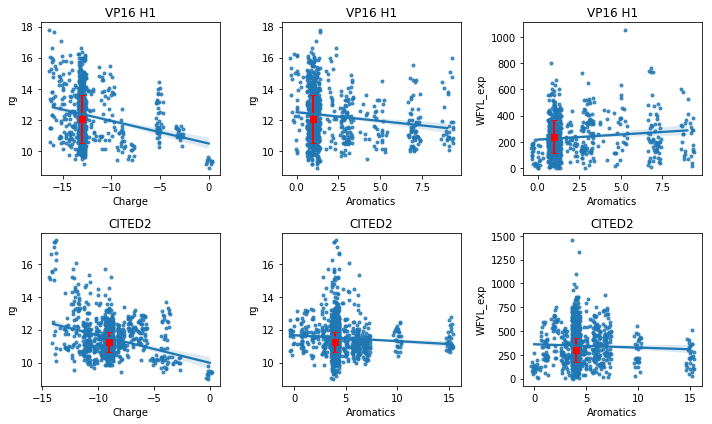

In [143]:
featurepairs = [['Charge','rg'],['Aromatics','rg'],['Aromatics','WFYL_exp']]

labelDict = {'rg':'Radius of gyration (size)','Charge':'Charge','Aromatics':'Aromatics','WFY_exp_norm':'Normalized exposure of aromatics',
             'CountFYWL': 'W,F,Y,L Count', 'WFYL_exp_norm':'Normalized exposure of W,F,Y,L',
            'WFYL_exp':'Exposure of W,F,Y,L'}
# for yfeature in ['rg','WFYL_exp','WFY_exp','trp', 'phe','tyr', 'leu']:
fig = plt.figure(figsize=(10,6))
for j,featurepair in enumerate(featurepairs):
    xfeature,yfeature = featurepair    
    for k,ad in enumerate([vp16,cited]):
#             for j,simtype in enumerate(['coil_start','helical_start']):
        plt.subplot(2,3,1+j+3*k)
#         indx = SimDF[ad]&SimDF.PerturbAromatics&(SimDF.sim_type=='coil_start')
        indx = SimDF[ad]&(SimDF.sim_type=='coil_start')&(SimDF.Charge<1)
        tempDF = SimDF[indx]

        wt = SimDF[ad] & SimDF.WT&(SimDF.sim_type=='coil_start')
        tempwt = SimDF[wt]
        wtmean= np.mean(tempwt[yfeature])
        wtstd = np.std(tempwt[yfeature])
        x = np.median(tempwt[xfeature])
#             plt.scatter(tempwt[xfeature]+1,tempwt[yfeature],c='r',s=1)

        plt.title(TitleDict[ad])
        plt.errorbar(x,wtmean,wtstd,fmt='s',capsize=3, elinewidth=2,c='r')

        sns.regplot(x=xfeature,y=yfeature,data=tempDF,x_jitter=.4,marker='.',order=1)

        
plt.tight_layout()

plt.savefig('Figures/'+Folder+'20211004_SimsSuppFigScatter.pdf')
plt.show()

## Plot Helicity along the sequence

In [ ]:
import unicodedata
  

def plotHelicitySet(ad,mutset,makepdf=False):
    if (os.path.isdir('Figures/'+Folder+'Helicities/'))==False:
        os.mkdir('Figures/'+Folder+'Helicities/')
    if (os.path.isdir('Figures/'+Folder+'Helicities/'+ad+'/'))==False:
        os.mkdir('Figures/'+Folder+'Helicities/'+ad)
    ColorsDict = {'coil_start':'r','helical_start':'b','WT':'k'}

    #WT coild start 
    indx = (SimDF[ad]==True)&(SimDF['WT']==True)&(SimDF.sim_type=='coil_start')
    wtDF = SimDF[indx]
    tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
    j=0
    for i, entry in wtDF.iterrows():
        temp = (entry['H_vector'])
        temp = temp[1:-1]
        coilvec = [float(idx) for idx in temp.split(', ')]
        tempMatrix[j,:]=coilvec
        j+=1
    wtMeanCoil = np.mean(tempMatrix,axis=0)
    wtSTDCoil = np.std(tempMatrix,axis=0)/ np.sqrt(tempMatrix.shape[0])
    # WT helix start
    indx = (SimDF[ad]==True)&(SimDF['WT']==True)&(SimDF.sim_type=='helical_start')
    wtDF = SimDF[indx]
    tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
    j=0
    for i, entry in wtDF.iterrows():
        temp = (entry['H_vector'])
        temp = temp[1:-1]
        coilvec = [float(idx) for idx in temp.split(', ')]
        tempMatrix[j,:]=coilvec
        j+=1
    wtMeanHelix = np.mean(tempMatrix,axis=0)
    wtSTDHelix = np.std(tempMatrix,axis=0)/ np.sqrt(tempMatrix.shape[0])
    
    indx = (SimDF[ad]==True)&(SimDF[mutset]==True)
    tempDF = SimDF[indx]
    firstplot = True
    for sim_id in sorted(set(tempDF.sim_id)):
        for sim_type in set(tempDF.sim_type):
            indx = (tempDF.sim_id==sim_id)&(tempDF.sim_type==sim_type)
            tempDF2 = tempDF[indx]
            tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
            j=0
            for i, entry in tempDF2.iterrows():
                temp = (entry['H_vector'])
                temp = temp[1:-1]
                coilvec = [float(idx) for idx in temp.split(', ')]
                tempMatrix[j,:]=coilvec
                j+=1
            tempMean = np.mean(tempMatrix,axis=0)
            tempSTD = np.std(tempMatrix,axis=0)/ np.sqrt(tempMatrix.shape[0])
#             plt.plot(np.arange(0,len(coilvec)),tempMean,c=ColorsDict[sim_type],label=sim_type)
            plt.errorbar(np.arange(0,len(coilvec)),tempMean,yerr=tempSTD,c=ColorsDict[sim_type],label=sim_type)
#         plt.plot(np.arange(0,len(coilvec)),wtMeanCoil,'r:',label='WT coil start')
        plt.errorbar(np.arange(0,len(coilvec)),wtMeanCoil,yerr=wtSTDCoil,c='r',linestyle='dotted',alpha=.4,label='WT coil start')
#         plt.plot(np.arange(0,len(coilvec)),wtMeanHelix,'b:',label='WT helical start')
        plt.errorbar(np.arange(0,len(coilvec)),wtMeanHelix,yerr=wtSTDHelix,c='b',linestyle='dotted',alpha=.4,label='WT helical start')
        if firstplot:
            plt.legend(loc=1)
            firstplot=False
        
        plt.xticks(np.arange(0,len(coilvec)),tempDF2.ADseq.values[0]),#plt.xlabel('Position'),
        name = TitleDict[ad]+' '+tempDF2.shortname.values[0]
        plt.ylabel('Helicity'),plt.ylim(0,1),plt.title(name)
        if makepdf:
            plt.savefig('Figures/'+Folder+'Helicities/'+ad+'/Helicities_'+sim_id+'.pdf')
        else:
            plt.savefig('Figures/'+Folder+'Helicities/'+ad+'/Helicities_'+sim_id+'.png')
        plt.show()
        
plotHelicitySet(vp16,'WT')
plotHelicitySet(cited,'WT')

In [ ]:
import unicodedata
TitleDict ={'CITED2_N':'CITED2', 'Hif1-AD2_46':'Hif1'+unicodedata.lookup('greek small letter alpha'), 'vp16N_C':'VP16 H1', 'stat3':'Stat3', 'p65':'p65'}
  

def plotHelicitySet_many(ad,mutset,Ntall,Nwide):
    ColorsDict = {'coil_start':'r','helical_start':'b','WT':'k'}
    fig = plt.figure(figsize=(8,8))
    #WT coild start 
    indx = (SimDF[ad]==True)&(SimDF['WT']==True)&(SimDF.sim_type=='coil_start')
    wtDF = SimDF[indx]
    tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
    j=0
    for i, entry in wtDF.iterrows():
        temp = (entry['H_vector'])
        temp = temp[1:-1]
        coilvec = [float(idx) for idx in temp.split(', ')]
        tempMatrix[j,:]=coilvec
        j+=1
    wtMeanCoil = np.mean(tempMatrix,axis=0)
    wtSTDCoil = np.std(tempMatrix,axis=0)/ np.sqrt(tempMatrix.shape[0])
    # WT helix start
    indx = (SimDF[ad]==True)&(SimDF['WT']==True)&(SimDF.sim_type=='helical_start')
    wtDF = SimDF[indx]
    tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
    j=0
    for i, entry in wtDF.iterrows():
        temp = (entry['H_vector'])
        temp = temp[1:-1]
        coilvec = [float(idx) for idx in temp.split(', ')]
        tempMatrix[j,:]=coilvec
        j+=1
    wtMeanHelix = np.mean(tempMatrix,axis=0)
    wtSTDHelix = np.std(tempMatrix,axis=0)/ np.sqrt(tempMatrix.shape[0])
    
    indx = (SimDF[ad]==True)&(SimDF[mutset]==True)
    tempDF = SimDF[indx]
    for k, sim_id in enumerate(sorted(set(tempDF.sim_id))):
        plt.subplot(Ntall,Nwide,k+1)
        for sim_type in set(tempDF.sim_type):
            indx = (tempDF.sim_id==sim_id)&(tempDF.sim_type==sim_type)
            tempDF2 = tempDF[indx]
            tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
            j=0
            for i, entry in tempDF2.iterrows():
                temp = (entry['H_vector'])
                temp = temp[1:-1]
                coilvec = [float(idx) for idx in temp.split(', ')]
                tempMatrix[j,:]=coilvec
                j+=1
            tempMean = np.mean(tempMatrix,axis=0)
            tempSTD = np.std(tempMatrix,axis=0)/ np.sqrt(tempMatrix.shape[0])
            plt.errorbar(np.arange(0,len(coilvec)),tempMean,yerr=tempSTD,c=ColorsDict[sim_type],label=sim_type)
        plt.errorbar(np.arange(0,len(coilvec)),wtMeanCoil,yerr=wtSTDCoil,c='r',linestyle='dotted',alpha=.4,label='WT coil start')
        plt.errorbar(np.arange(0,len(coilvec)),wtMeanHelix,yerr=wtSTDHelix,c='b',linestyle='dotted',alpha=.4,label='WT helical start')

        
        plt.xticks(np.arange(0,len(coilvec)),tempDF2.ADseq.values[0]),#plt.xlabel('Position'),
        name = TitleDict[ad]+' '+sim_id+' '+tempDF2.shortname.values[0]
        plt.ylabel('Helicity'),plt.ylim(0,1),plt.title(name)
        if k ==0:
            plt.legend(loc=1)
        
    plt.savefig('Figures/'+Folder+'CheckBoard_'+ad+'_'+mutset+'.pdf')
    plt.tight_layout()
    plt.show()
        
plotHelicitySet_many(vp16,'Shuffle',3,3)
# plotHelicitySet(cited,'WT')

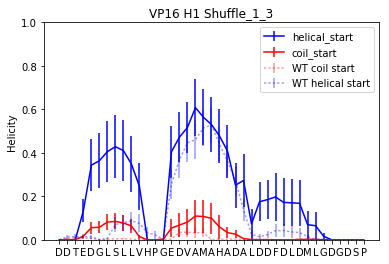

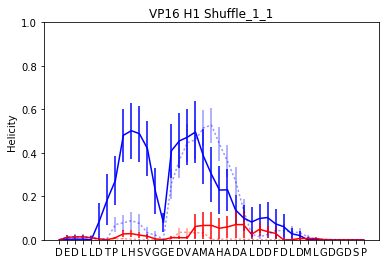

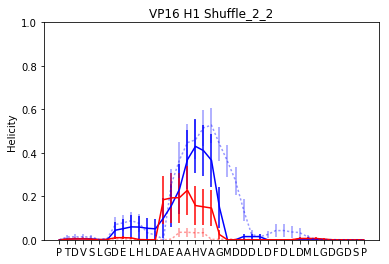

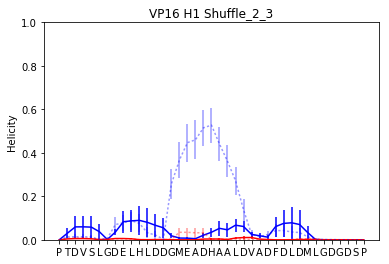

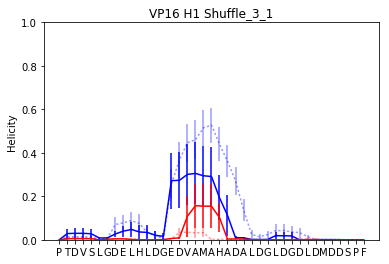

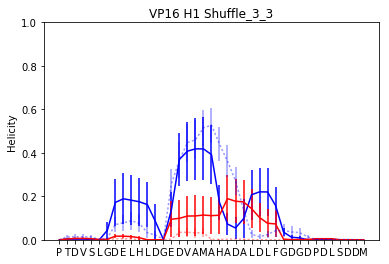

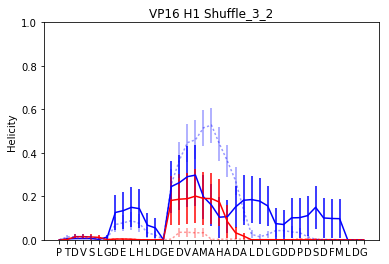

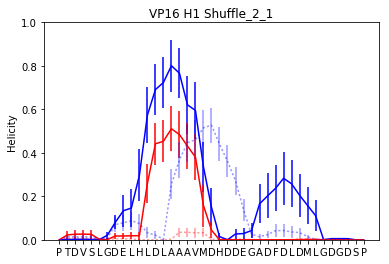

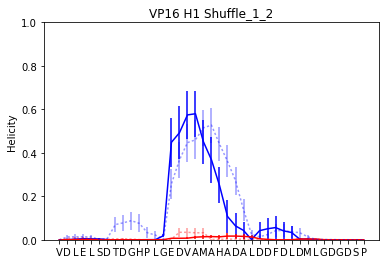

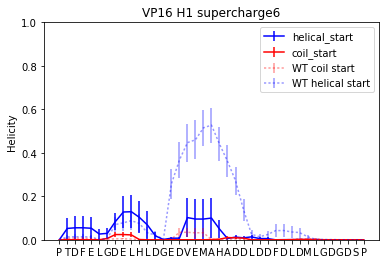

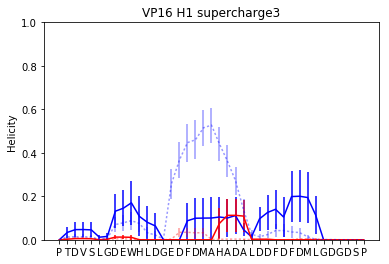

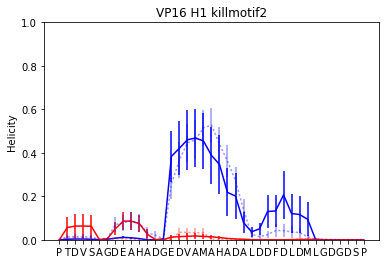

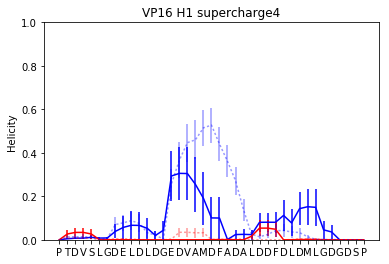

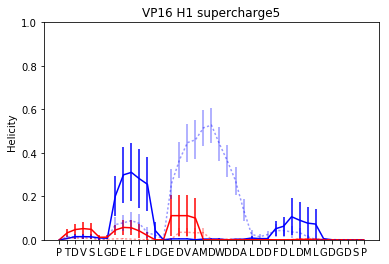

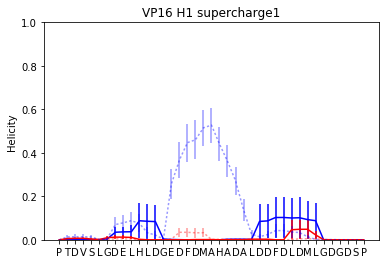

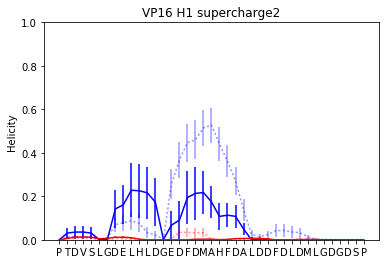

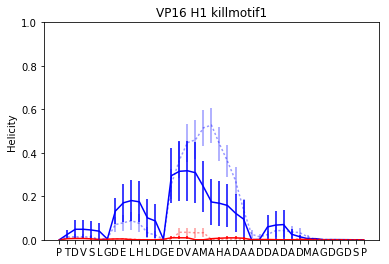

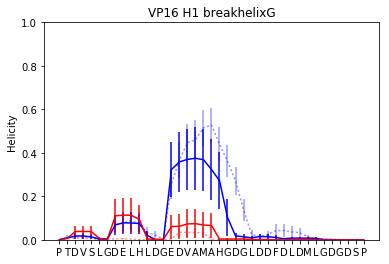

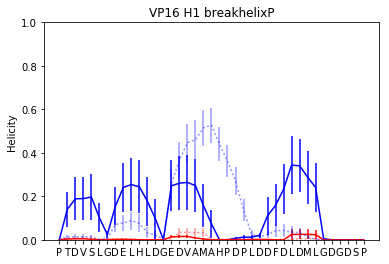

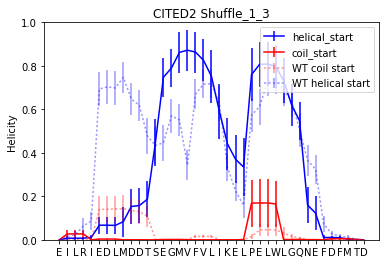

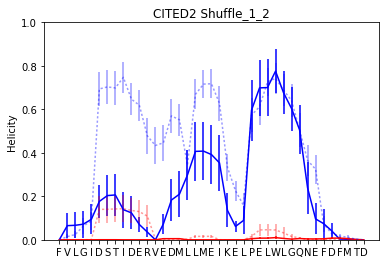

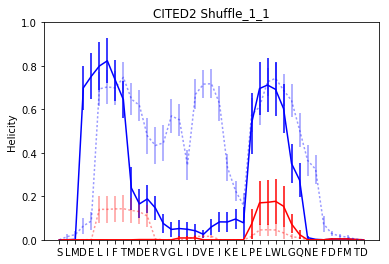

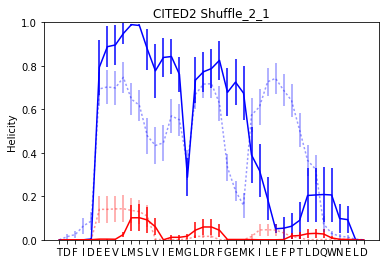

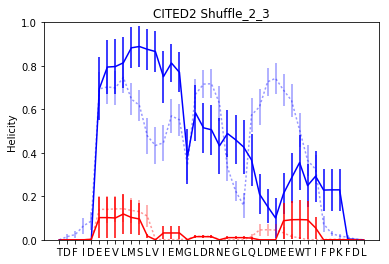

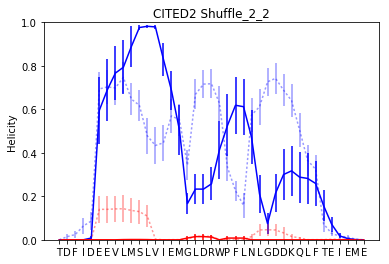

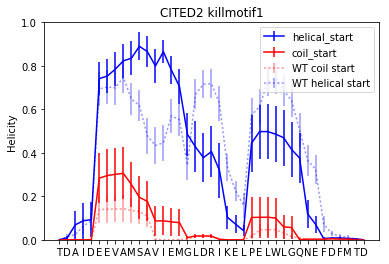

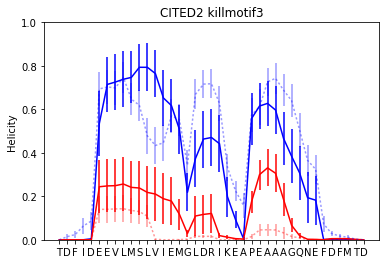

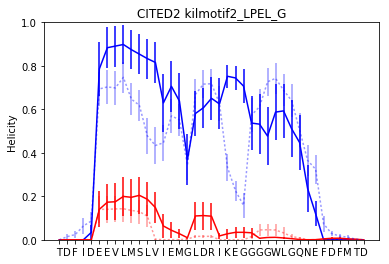

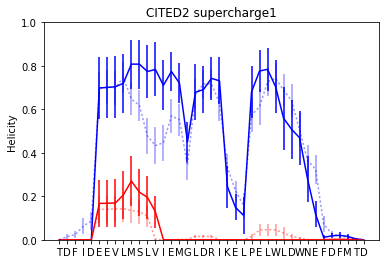

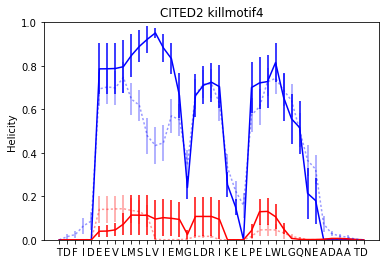

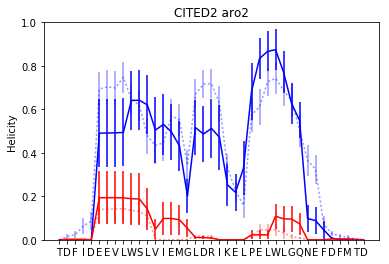

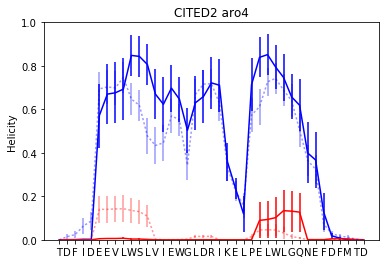

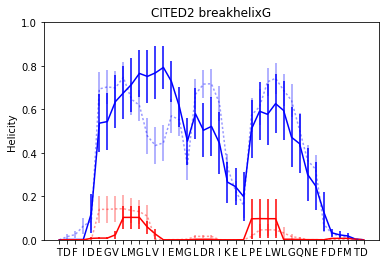

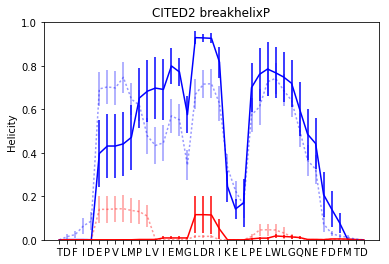

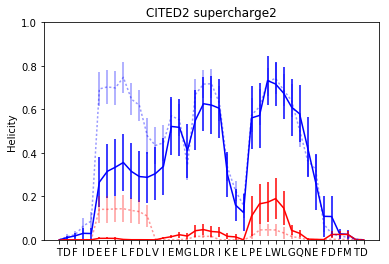

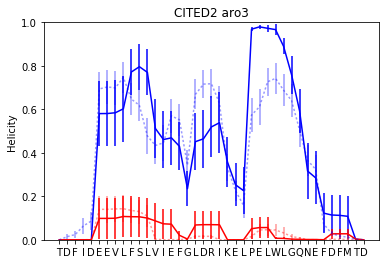

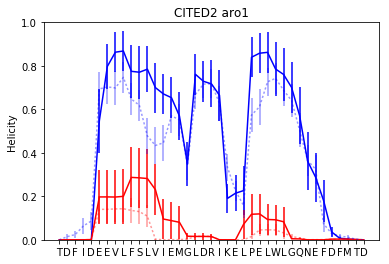

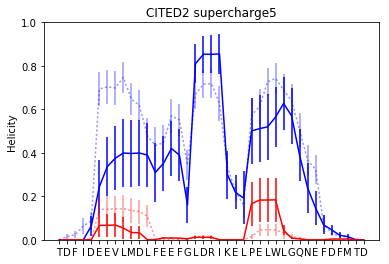

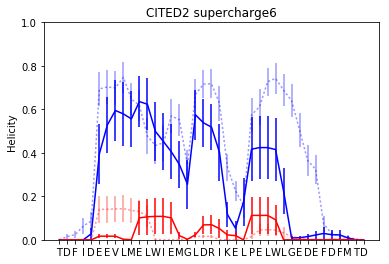

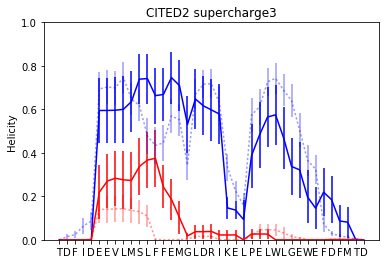

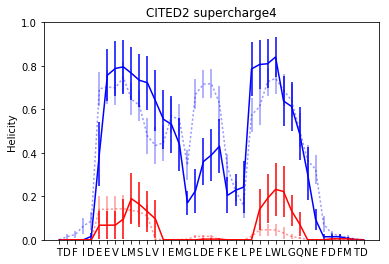

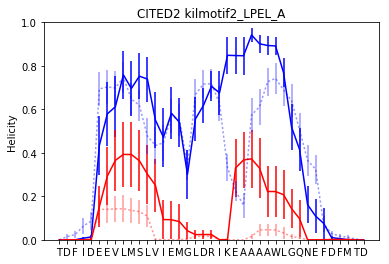

In [124]:
plotHelicitySet(vp16,'Shuffle',makepdf=True)
plotHelicitySet(vp16,'HandDesigned',makepdf=True)
plotHelicitySet(cited,'Shuffle',makepdf=True)
plotHelicitySet(cited,'HandDesigned',makepdf=True)

In [ ]:
ad = vp16
for mutset in ['HandDesigned','Shuffle','PerturbCharge']:
    plotHelicitySet(ad,mutset)

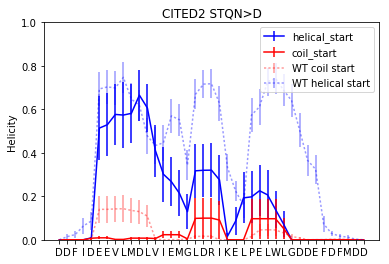

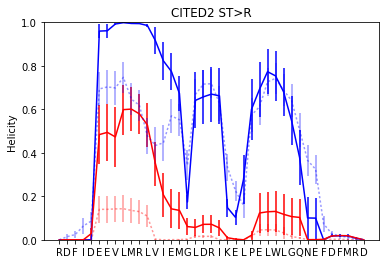

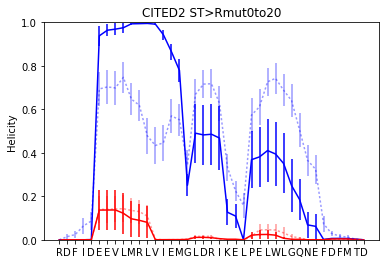

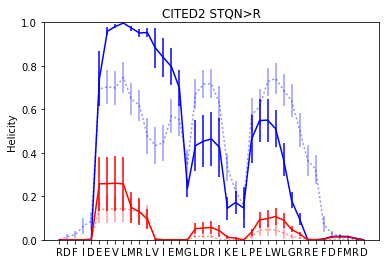

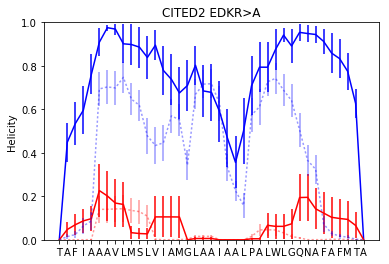

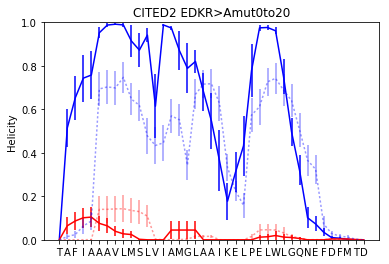

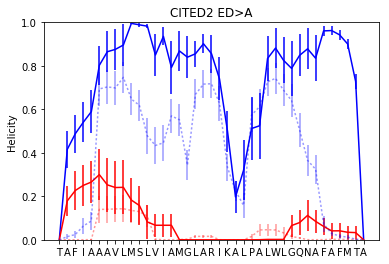

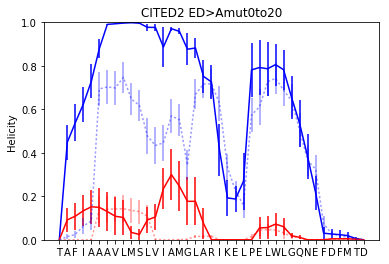

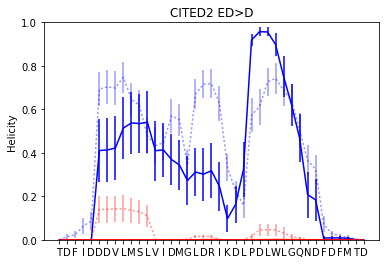

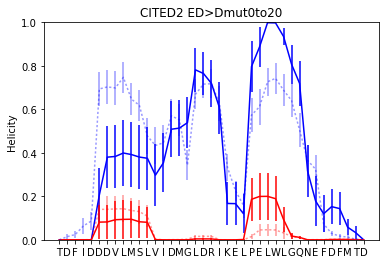

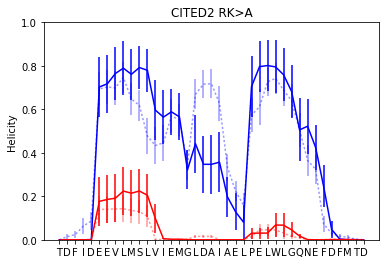

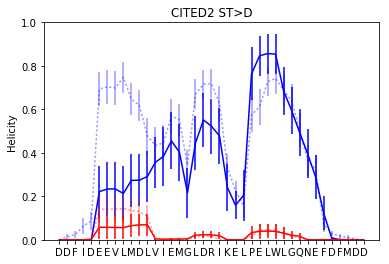

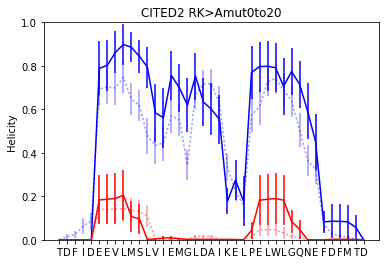

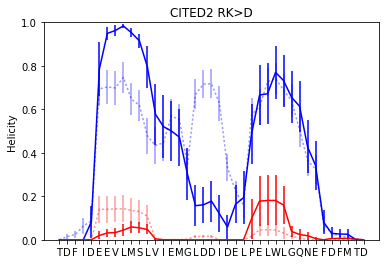

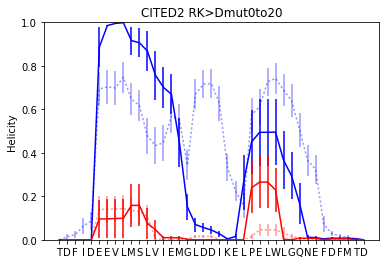

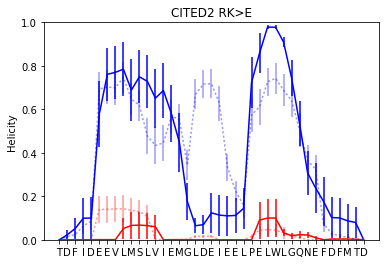

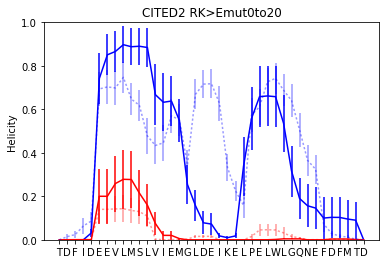

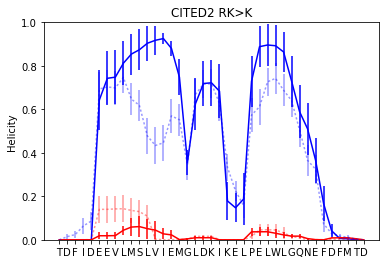

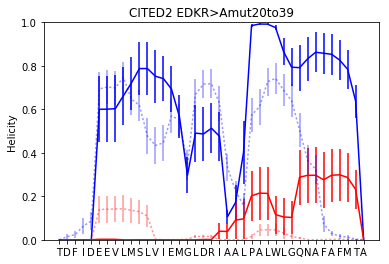

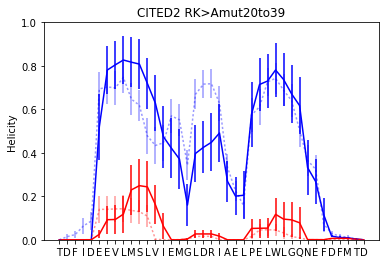

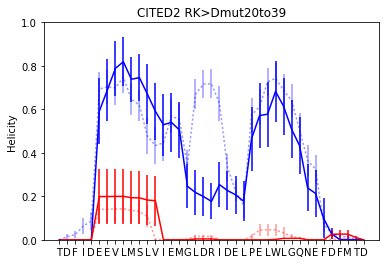

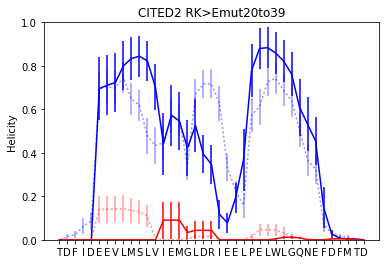

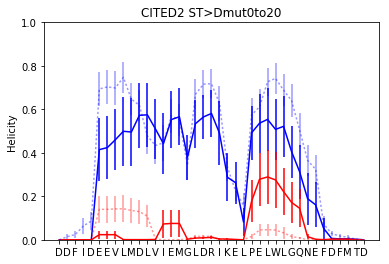

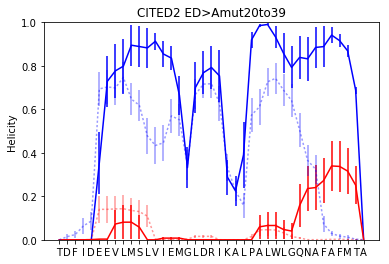

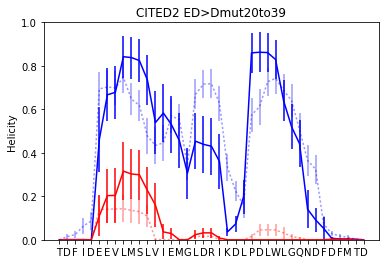

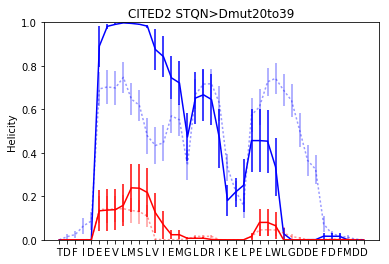

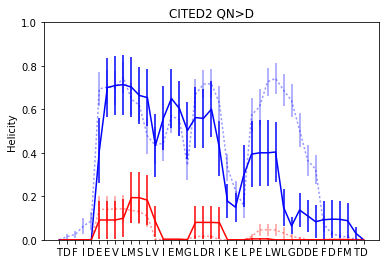

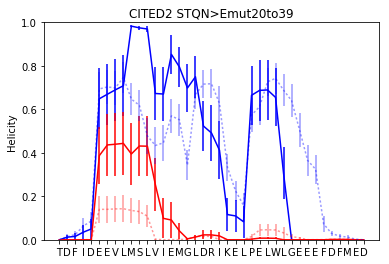

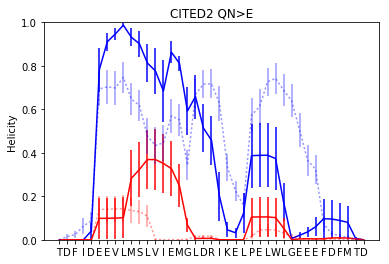

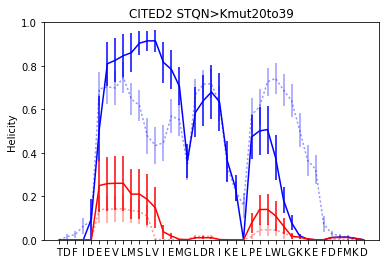

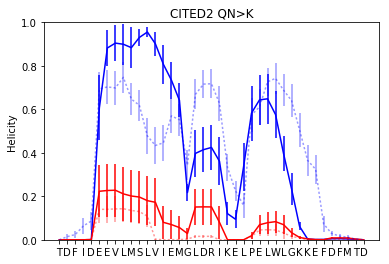

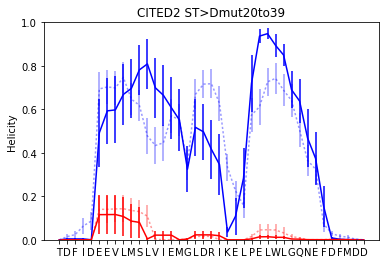

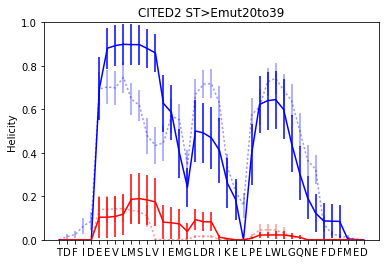

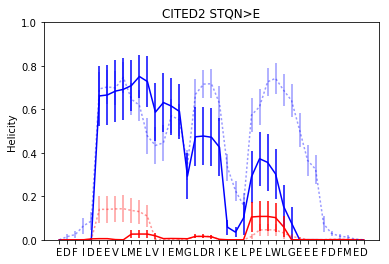

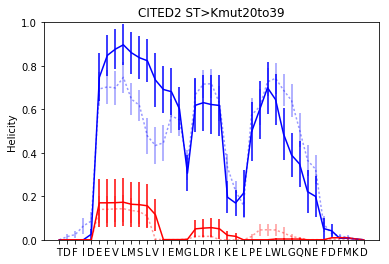

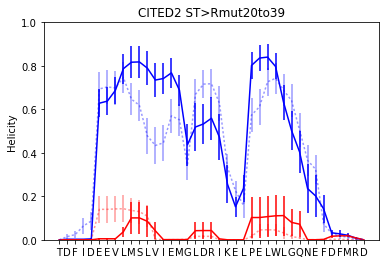

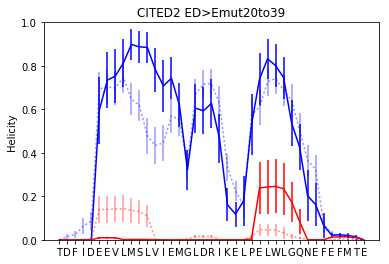

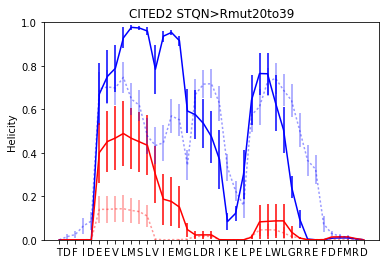

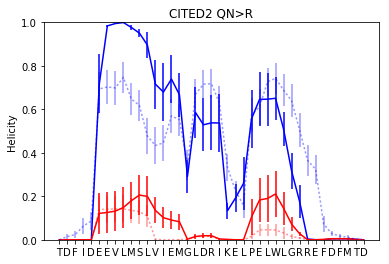

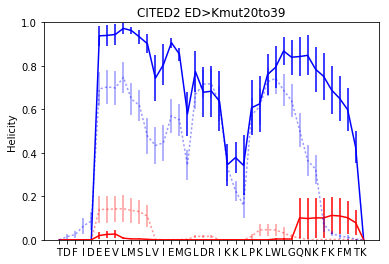

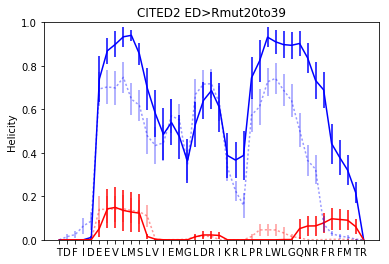

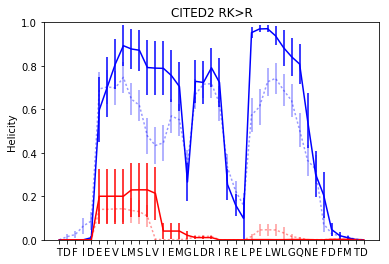

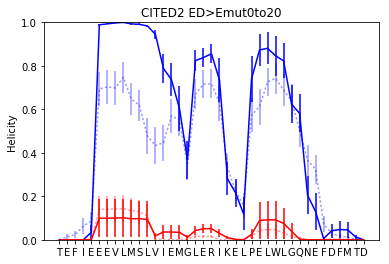

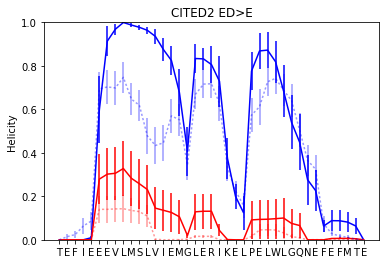

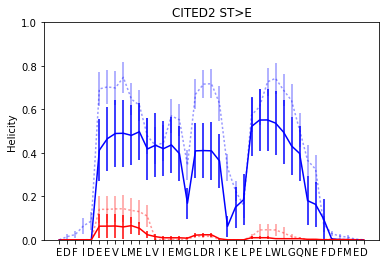

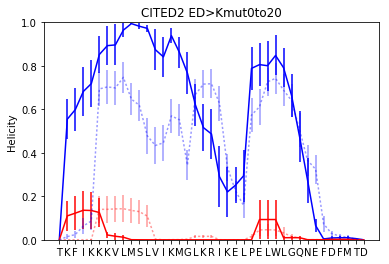

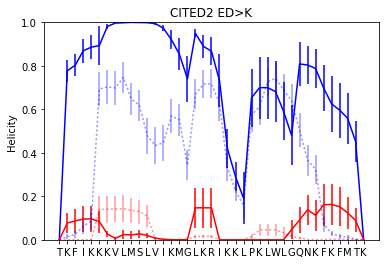

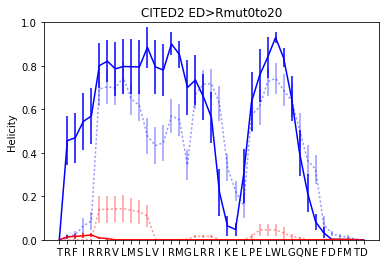

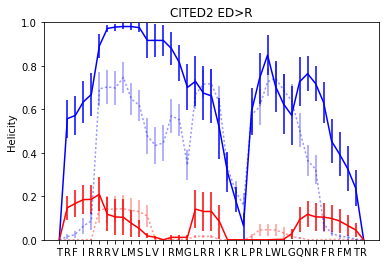

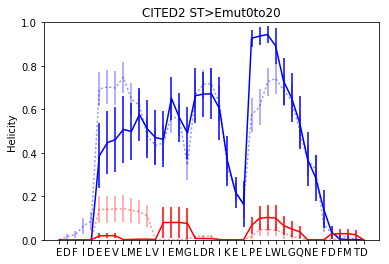

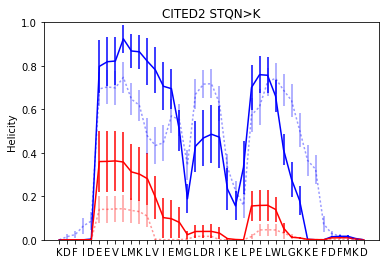

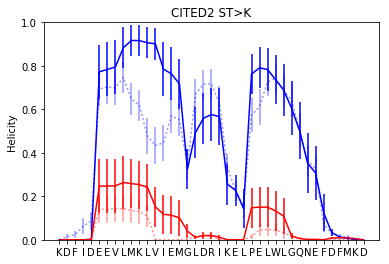

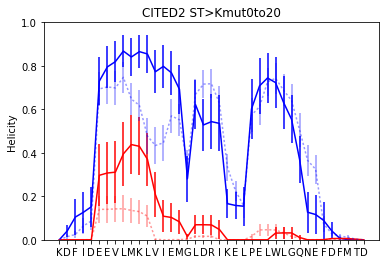

In [27]:
ad = cited
# for mutset in ['HandDesigned','Shuffle','PerturbCharge']:
for mutset in ['PerturbCharge']:
    plotHelicitySet(ad,mutset)

# Integrate Helicity

there 30 WT sims


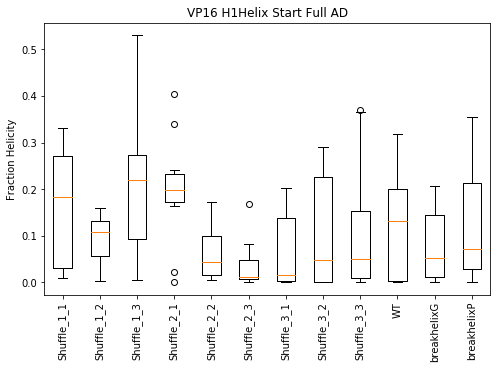

there 30 WT sims


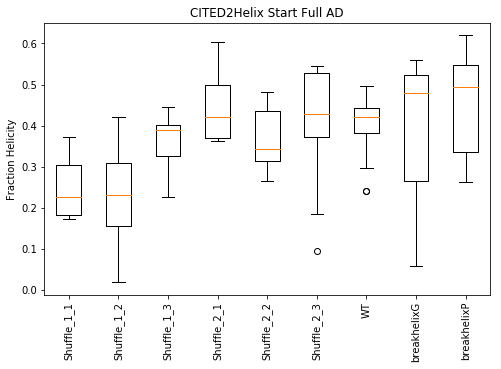

In [56]:
import unicodedata
import seaborn
TitleDict ={'CITED2_N':'CITED2', 'Hif1-AD2_46':'Hif1'+unicodedata.lookup('greek small letter alpha'), 'vp16N_C':'VP16 H1', 'stat3':'Stat3', 'p65':'p65'}

helixCoords = {vp16:[14,33],cited:[4,16]}
indx = SimDF.Shuffle+ (SimDF.shortname=='breakhelixG')+(SimDF.shortname=='breakhelixP')
indx = indx>0
SimDF['SimIngegralSuppFig']=indx

def plotmyBoxplot(mylist,title,simnames):
    fig = plt.figure(figsize=(8,5))
    sortedList = [x for _,x in sorted(zip(simnames,mylist))]
    Sortedsimnames= sorted(simnames)
    plt.boxplot(sortedList)
    plt.xticks(np.arange(1,1+len(Sortedsimnames)),Sortedsimnames,rotation=90),#plt.xlabel('Position'),
    plt.ylabel('Fraction Helicity')#,plt.ylim(0,1),
    plt.title(title)
    
def plotHelicityIntegral(ad,mutset):
    ColorsDict = {'coil_start':'r','helical_start':'b','WT':'k'}
    helixStart, helixEnd = helixCoords[ad]
    #WT coild start 
    indx = (SimDF[ad]==True)&(SimDF['WT']==True)&(SimDF.sim_type=='coil_start')
    wtDF = SimDF[indx]
    tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
    j=0
    for i, entry in wtDF.iterrows():
        temp = (entry['H_vector'])
        temp = temp[1:-1]
        coilvec = [float(idx) for idx in temp.split(', ')]
        tempMatrix[j,:]=coilvec
        j+=1
    wtLength = len(WTname2seqDict[ad])
    wtMeanCoil = np.sum(tempMatrix,axis=1)*1/wtLength
    wtMeanCoil_overhelix = np.sum(tempMatrix[helixStart:helixEnd,:],axis=1)**1/(helixEnd-helixStart)
    print 'there %i WT sims'%len(wtMeanCoil)
    # WT helix start
    indx = (SimDF[ad]==True)&(SimDF['WT']==True)&(SimDF.sim_type=='helical_start')
    wtDF = SimDF[indx]
    tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
    j=0
    for i, entry in wtDF.iterrows():
        temp = (entry['H_vector'])
        temp = temp[1:-1]
        coilvec = [float(idx) for idx in temp.split(', ')]
        tempMatrix[j,:]=coilvec
        j+=1
    
    wtMeanHelix = np.sum(tempMatrix,axis=1)*1/wtLength
    wtMeanHelix_overhelix = np.sum(tempMatrix[helixStart:helixEnd,:],axis=1)**1/(helixEnd-helixStart)
    
    FullIntegrals_coil,FullIntegrals_helix  = [wtMeanCoil],[wtMeanHelix]
    HelixIntegrals_coil,HelixIntegrals_helix  = [wtMeanCoil_overhelix],[wtMeanHelix_overhelix]
    simnames = ['WT']
    indx = (SimDF[ad]==True)&(SimDF[mutset]==True)
    tempDF = SimDF[indx]
    tempDF = tempDF.sort_values(by='sim_id')
    for k, sim_id in enumerate(sorted(set(tempDF.sim_id))):
        for sim_type in set(tempDF.sim_type):
            indx = (tempDF.sim_id==sim_id)&(tempDF.sim_type==sim_type)
            tempDF2 = tempDF[indx]
            tempMatrix = np.zeros((sum(indx),len(WTname2seqDict[ad])))
            j=0
            for i, entry in tempDF2.iterrows():
                temp = (entry['H_vector'])
                temp = temp[1:-1]
                coilvec = [float(idx) for idx in temp.split(', ')]
                tempMatrix[j,:]=coilvec
                j+=1
            tempIntegral = np.sum(tempMatrix,axis=1)*1/wtLength # helicity of full seq
            # helicity over helix
            tempMatrix = tempMatrix[:,helixStart:helixEnd]
#             print tempMatrix
            tempIntegral_overhelix = np.sum(tempMatrix,axis=1)*1/(helixEnd-helixStart)
            if sim_type == 'coil_start':
                FullIntegrals_coil.append(tempIntegral)
                HelixIntegrals_coil.append(tempIntegral_overhelix)
                simnames.append(entry.shortname)
            if sim_type =='helical_start':
                FullIntegrals_helix.append(tempIntegral)
                HelixIntegrals_helix.append(tempIntegral_overhelix)
    #plot helix start
    title = TitleDict[ad] + 'Helix Start Full AD'
    plotmyBoxplot(FullIntegrals_helix,title,simnames)
#     title = TitleDict[ad] + 'Helix Start Helix Region'
#     plotmyBoxplot(HelixIntegrals_helix,title,simnames)
    #plot coil start
#     title = TitleDict[ad] + 'Coil Start Full AD'
#     plotmyBoxplot(FullIntegrals_coil,title,simnames)
#     title = TitleDict[ad] + 'Coil Start Helix Region'
#     plotmyBoxplot(HelixIntegrals_coil,title,simnames)
    
    filename = 'Figures/'+Folder+"HelicityIntegrals_"+ad+".pdf"

    plt.savefig(filename)
    plt.show()
        
plotHelicityIntegral(vp16,'SimIngegralSuppFig')
plotHelicityIntegral(cited,'SimIngegralSuppFig')

# plotHelicitySet(cited,'WT')

there 30 WT sims


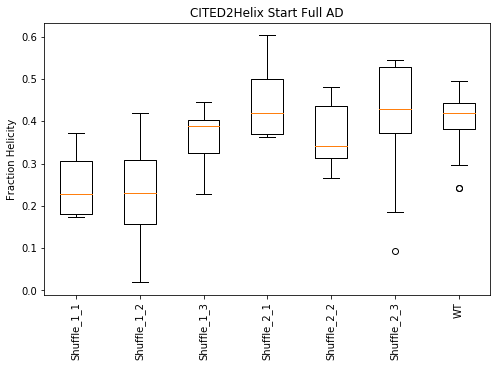

there 30 WT sims


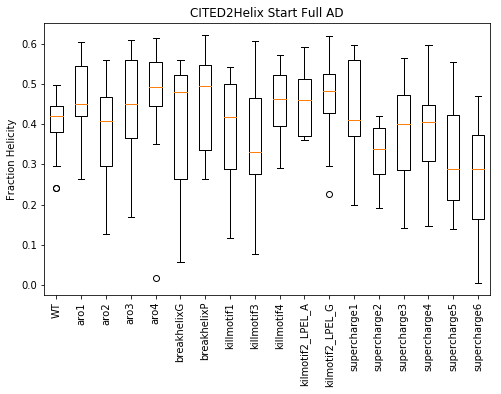

In [51]:
plotHelicityIntegral(cited,'Shuffle')
plotHelicityIntegral(cited,'HandDesigned')
